# VGG
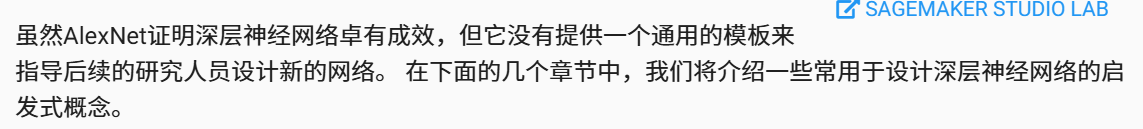
之前的结构并不清晰 且很混乱
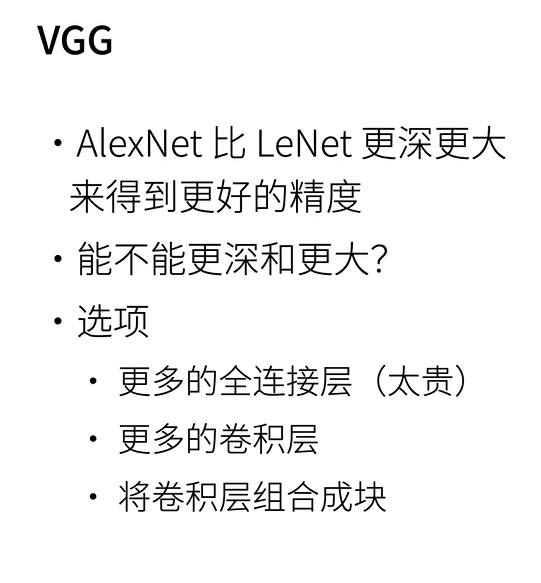
VGG将之前的ALEX的结构变的更清晰

提出了一个VGG块的思路

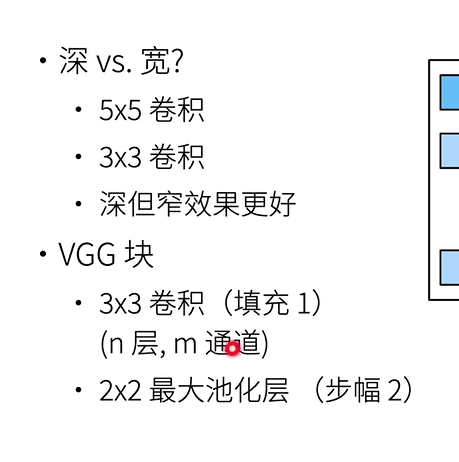
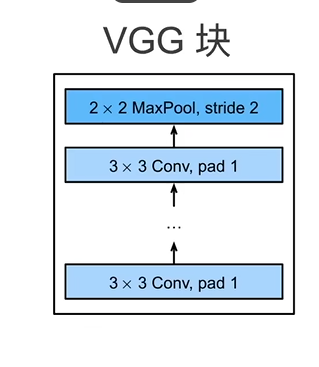

# VGG架构
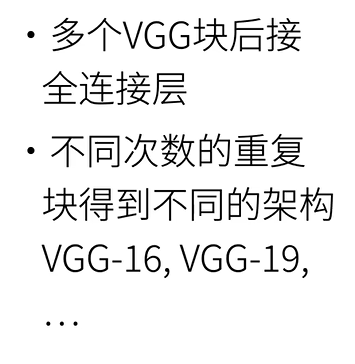

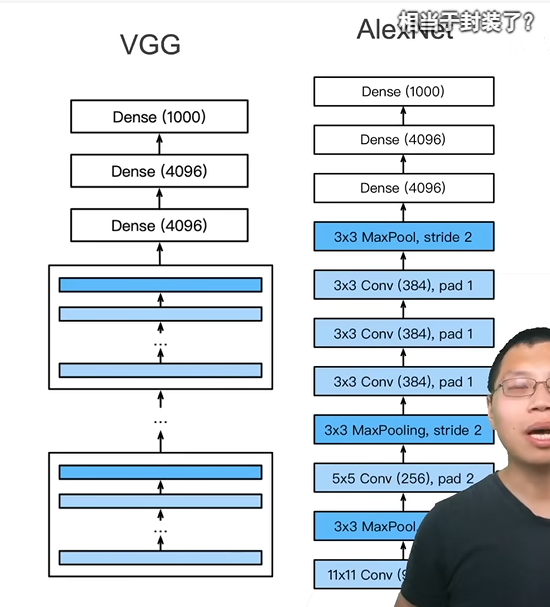

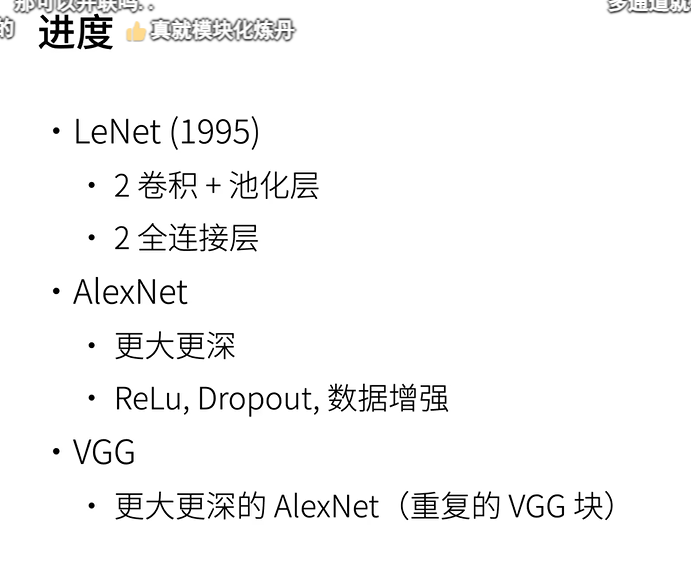

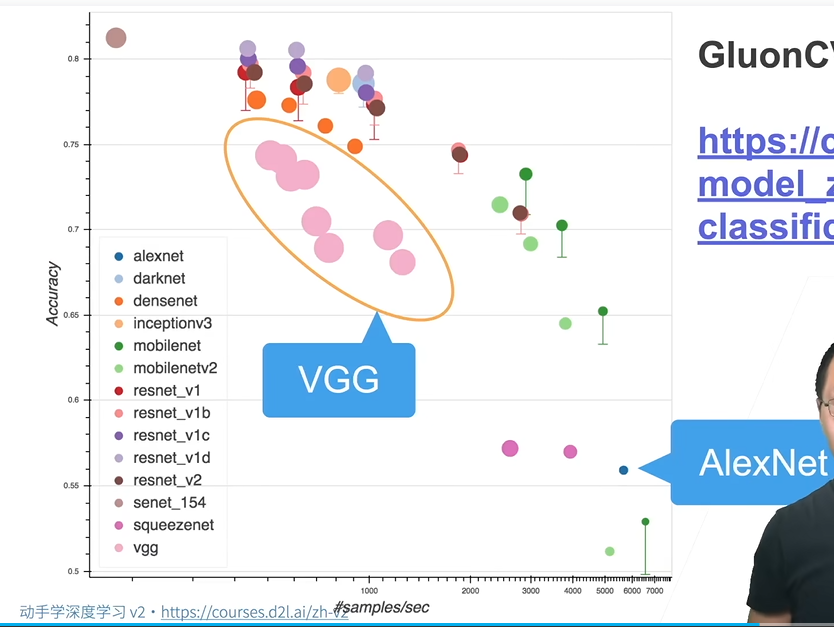

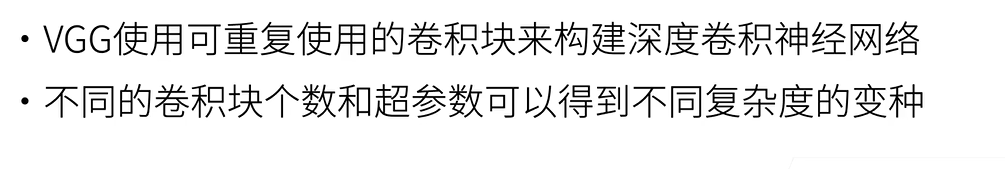

经典卷积神经网络的基本组成部分是下面的这个序列：
带填充以保持分辨率的卷积层；

非线性激活函数，如ReLU；

汇聚层，如最大汇聚层。

In [2]:
# 使用块的网络（VGG）
import torch
from torch import nn
from d2l import torch as d2l

#用于构建VGG网络模块
# VGG 网络是一种经典的卷积神经网络架构，通常用于图像分类任务

import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
#     """
#     创建一个 VGG 块。

#     参数：
#     num_convs -- 卷积层的数量
#     in_channels -- 输入通道数
#     out_channels -- 输出通道数

#     返回：
#     一个包含多个卷积层和一个最大池化层的 nn.Sequential 对象
#     """
    layers = []
    for _ in range(num_convs):
        # 添加卷积层
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        # 添加激活函数
        layers.append(nn.ReLU())
        # 更新 in_channels 为 out_channels，以便下一个卷积层使用
        in_channels = out_channels
    # 添加最大池化层
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    # 将所有层组合为一个 nn.Sequential 对象
    return nn.Sequential(*layers)

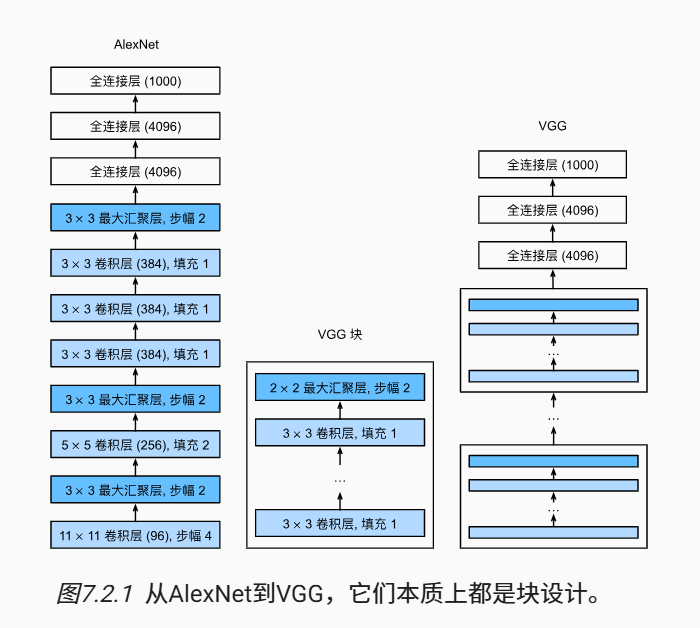

In [3]:
# 第一个数值表示该模块中卷积层的数量，第二个数值表示该模块中卷积层的输出通道数

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1  # 假设输入通道数为1，例如灰度图像
    # 构建卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    # 使用nn.Sequential将卷积层和全连接层组合在一起
    return nn.Sequential(
        *conv_blks,  # 卷积层部分
        nn.Flatten(),  # 展平操作
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)  # 输出层，10个类别
    )

net = vgg(conv_arch)

In [5]:
#观察每个层输出的形状
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)
    
#前5个为VGG块 
# 224x224的数据进来
#第一块 高宽减半 通道拉到64
#
# 最后一层变为512通道 在将高宽变为7x7
#后5层为线性层

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [6]:
ratio = 4
#构建一个之前通道数/4的新网络
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.183, train acc 0.932, test acc 0.922
989.9 examples/sec on cuda:0


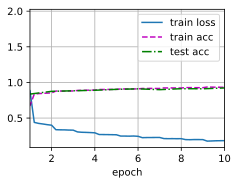

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 与Alex对比 这里用了8的卷积层 3个全连接层==》即11VGG 比Alex效果更好 


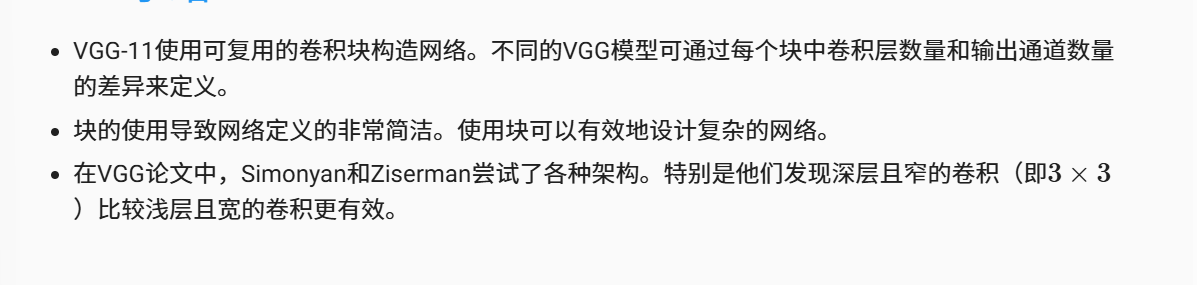